https://www.kaggle.com/carmnejsu/sales-forecast-lstm-67-beginner-friendly

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

from matplotlib import pylab as plt
import matplotlib.dates as mdates #시계열 시각화
plt.rcParams['figure.figsize'] = (15, 8)

import seaborn as sns

['items.csv', 'sample_submission.csv', 'test.csv', 'sales_train.csv', 'item_categories.csv', 'shops.csv']


In [4]:
path = '../input/'
sub = pd.read_csv(path +'sample_submission.csv')
sub.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [9]:
train = pd.read_csv(path + 'sales_train.csv')
print('number of shops : ', len(set(train.shop_id)))
print('number of items : ', len(set(train.item_id)))

num_month = train['date_block_num'].max()
print('number of month : ', num_month)
print('size of train : ', train.shape)

train.head()


number of shops :  60
number of items :  21807
number of month :  33
size of train :  (2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
test = pd.read_csv(path +'test.csv')
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [8]:
items = pd.read_csv('../input/items.csv')
print ('number of categories: ', len(items['item_category_id'].unique())) # the maximun number of category id
items.head()

number of categories:  84


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [10]:
train_clean = train.drop(['date', 'item_price'], axis = 1)
train_clean.head()

,date_block_num,shop_id,item_id,item_cnt_day
0,0,59,22154,1.0
1,0,25,2552,1.0
2,0,25,2552,-1.0
3,0,25,2554,1.0
4,0,25,2555,1.0


In [12]:
train_clean = train_clean.groupby(['item_id', 'shop_id', 'date_block_num']).sum().reset_index().rename(columns = {'item_cnt_day' : 'item_cnt_month'})
train_clean = train_clean[["item_id","shop_id","date_block_num","item_cnt_month"]]
train_clean.head()

,item_id,shop_id,date_block_num,item_cnt_month
0,0,54,20,1.0
1,1,55,15,2.0
2,1,55,18,1.0
3,1,55,19,1.0
4,1,55,20,1.0


In [13]:
check = train_clean[["shop_id","item_id","date_block_num","item_cnt_month"]]
check = check[(check.shop_id == 5) & (check.item_id == 5037)]
check

,shop_id,item_id,date_block_num,item_cnt_month
400439,5,5037,20,1.0
400440,5,5037,22,1.0
400441,5,5037,23,2.0
400442,5,5037,24,2.0
400443,5,5037,28,1.0
400444,5,5037,29,1.0
400445,5,5037,30,1.0
400446,5,5037,31,3.0
400447,5,5037,32,1.0


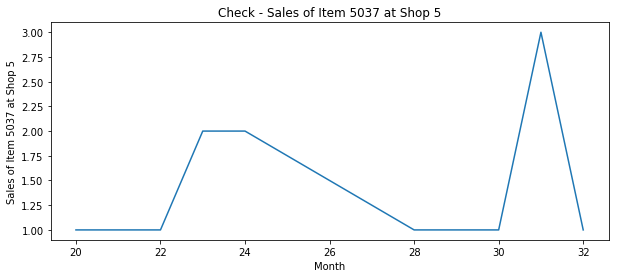

In [14]:
plt.figure(figsize = (10,4))
plt.title('Check - Sales of Item 5037 at Shop 5')
plt.xlabel('Month')
plt.ylabel('Sales of Item 5037 at Shop 5')
plt.plot(check.date_block_num, check.item_cnt_month)

In [17]:
month_list = [i for i in range(num_month + 1)]

shop = []
for i in range(num_month + 1) :
    shop.append(5)

item = []
for i in range(num_month + 1) :
    item.append(5037)
    
months_full = pd.DataFrame({'shop_id':shop, 'item_id':item,'date_block_num':month_list})
months_full

,shop_id,item_id,date_block_num
0,5,5037,0
1,5,5037,1
2,5,5037,2
3,5,5037,3
4,5,5037,4
5,5,5037,5
6,5,5037,6
7,5,5037,7
8,5,5037,8
9,5,5037,9


In [20]:
sales_33month = pd.merge(check, months_full, how = 'right')
sales_33month = sales_33month.sort_values(by = ['date_block_num'])
sales_33month.fillna(0, inplace = True)
sales_33month

,shop_id,item_id,date_block_num,item_cnt_month
9,5,5037,0,0.0
10,5,5037,1,0.0
11,5,5037,2,0.0
12,5,5037,3,0.0
13,5,5037,4,0.0
14,5,5037,5,0.0
15,5,5037,6,0.0
16,5,5037,7,0.0
17,5,5037,8,0.0
18,5,5037,9,0.0


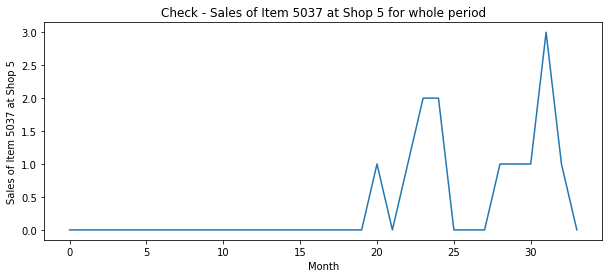

In [21]:
plt.figure(figsize=(10,4))
plt.title('Check - Sales of Item 5037 at Shop 5 for whole period')
plt.xlabel('Month')
plt.ylabel('Sales of Item 5037 at Shop 5')
plt.plot(sales_33month["date_block_num"],sales_33month["item_cnt_month"])

In [25]:
for i in range(1,6) :
    sales_33month['T_' + str(i)] = sales_33month.item_cnt_month.shift(i) #shift i만큼씩 lag

sales_33month.fillna(0, inplace = True)
sales_33month

,shop_id,item_id,date_block_num,item_cnt_month,T_1,T_2,T_3,T_4,T_5
9,5,5037,0,0.0,0.0,0.0,0.0,0.0,0.0
10,5,5037,1,0.0,0.0,0.0,0.0,0.0,0.0
11,5,5037,2,0.0,0.0,0.0,0.0,0.0,0.0
12,5,5037,3,0.0,0.0,0.0,0.0,0.0,0.0
13,5,5037,4,0.0,0.0,0.0,0.0,0.0,0.0
14,5,5037,5,0.0,0.0,0.0,0.0,0.0,0.0
15,5,5037,6,0.0,0.0,0.0,0.0,0.0,0.0
16,5,5037,7,0.0,0.0,0.0,0.0,0.0,0.0
17,5,5037,8,0.0,0.0,0.0,0.0,0.0,0.0
18,5,5037,9,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
df = sales_33month[['shop_id','item_id','date_block_num','T_1','T_2','T_3','T_4','T_5', 'item_cnt_month']].reset_index()
df = df.drop('index', axis = 1) #drop으로 바로 index 삭제 가능
df

,shop_id,item_id,date_block_num,T_1,T_2,T_3,T_4,T_5,item_cnt_month
0,5,5037,0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,5037,1,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5037,2,0.0,0.0,0.0,0.0,0.0,0.0
3,5,5037,3,0.0,0.0,0.0,0.0,0.0,0.0
4,5,5037,4,0.0,0.0,0.0,0.0,0.0,0.0
5,5,5037,5,0.0,0.0,0.0,0.0,0.0,0.0
6,5,5037,6,0.0,0.0,0.0,0.0,0.0,0.0
7,5,5037,7,0.0,0.0,0.0,0.0,0.0,0.0
8,5,5037,8,0.0,0.0,0.0,0.0,0.0,0.0
9,5,5037,9,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
train_df = df[:-3]
val_df = df[-3:]

x_train, y_train = train_df.drop('item_cnt_month', axis = 1), train_df.item_cnt_month
x_val, y_val = val_df.drop('item_cnt_month', axis = 1), val_df.item_cnt_month

print('X train shape : {} y train shape : {}'.format(x_train.shape, y_train.shape))
print('X valid shape : {} y valid shape : {}'.format(x_val.shape, y_val.shape))

X train shape : (31, 8) y train shape : (31,)
X valid shape : (3, 8) y valid shape : (3,)


In [35]:
y_val

31    3.0
32    1.0
33    0.0
Name: item_cnt_month, dtype: float64

# Modeling

In [37]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU

model_lstm = Sequential()
model_lstm.add(LSTM(15, input_shape = (1,8)))
model_lstm.add(Dense(1))
model_lstm.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['accuracy'])

In [38]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.fit_transform(x_val)

In [41]:
x_train_reshaped = x_train_scaled.reshape((x_train_scaled.shape[0], 1, x_train_scaled.shape[1]))
x_val_reshaped = x_valid_scaled.reshape((x_valid_scaled.shape[0], 1, x_valid_scaled.shape[1]))

In [42]:
history = model_lstm.fit(x_train_reshaped, y_train, validation_data=(x_val_reshaped, y_val),epochs=70, batch_size=12, verbose=2, shuffle=False)
y_pre = model_lstm.predict(x_val_reshaped)

Train on 31 samples, validate on 3 samples
Epoch 1/70
 - 1s - loss: 0.3902 - acc: 0.7742 - val_loss: 2.6986 - val_acc: 0.3333
Epoch 2/70
 - 0s - loss: 0.3816 - acc: 0.7742 - val_loss: 2.7141 - val_acc: 0.3333
Epoch 3/70
 - 0s - loss: 0.3762 - acc: 0.7742 - val_loss: 2.7238 - val_acc: 0.3333
Epoch 4/70
 - 0s - loss: 0.3712 - acc: 0.7742 - val_loss: 2.7308 - val_acc: 0.3333
Epoch 5/70
 - 0s - loss: 0.3664 - acc: 0.7742 - val_loss: 2.7364 - val_acc: 0.3333
Epoch 6/70
 - 0s - loss: 0.3618 - acc: 0.7742 - val_loss: 2.7410 - val_acc: 0.3333
Epoch 7/70
 - 0s - loss: 0.3572 - acc: 0.7742 - val_loss: 2.7450 - val_acc: 0.3333
Epoch 8/70
 - 0s - loss: 0.3527 - acc: 0.7742 - val_loss: 2.7488 - val_acc: 0.3333
Epoch 9/70
 - 0s - loss: 0.3483 - acc: 0.7742 - val_loss: 2.7523 - val_acc: 0.3333
Epoch 10/70
 - 0s - loss: 0.3440 - acc: 0.7742 - val_loss: 2.7556 - val_acc: 0.3333
Epoch 11/70
 - 0s - loss: 0.3398 - acc: 0.7742 - val_loss: 2.7591 - val_acc: 0.3333
Epoch 12/70
 - 0s - loss: 0.3356 - acc: 0.

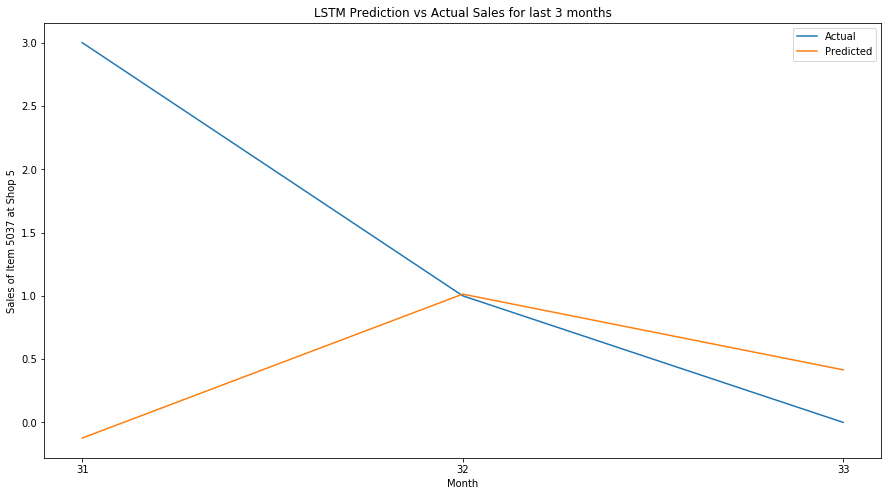

In [43]:
fig, ax = plt.subplots()
ax.plot(x_val['date_block_num'], y_val, label='Actual')
ax.plot(x_val['date_block_num'], y_pre, label='Predicted')
plt.title('LSTM Prediction vs Actual Sales for last 3 months')
plt.xlabel('Month')
plt.xticks(x_val['date_block_num'])
plt.ylabel('Sales of Item 5037 at Shop 5')
ax.legend()
plt.show()

In [44]:
from sklearn.metrics import mean_squared_error
from numpy import sqrt
rmse = sqrt(mean_squared_error(y_val,y_pre))
print('Val RMSE: %.3f' % rmse)

Val RMSE: 1.819


# consider Every cases

In [51]:
train_clean = train_clean[['item_id', 'shop_id','date_block_num', 'item_cnt_month']]
train_clean.head()

,item_id,shop_id,date_block_num,item_cnt_month
0,0,54,20,1.0
1,1,55,15,2.0
2,1,55,18,1.0
3,1,55,19,1.0
4,1,55,20,1.0


In [77]:
unique_combi = train_clean.groupby(['item_id', 'shop_id']).size().reset_index().drop(0, axis = 1)
len(unique_combi)

424124

In [79]:
unique_combi = pd.concat([unique_combi] * 34, ignore_index = True).sort_values(['item_id','shop_id']).reset_index(drop = True)
unique_combi['date_block_num'] = pd.concat([pd.Series(range(34))] * 424124, ignore_index = True)
unique_combi.head(3)

,item_id,shop_id,date_block_num
0,0,54,0
1,0,54,1
2,0,54,2


In [81]:
train_clean = pd.merge(unique_combi, train_clean, how = 'left').fillna(0)
for i in range(1,6) :
    train_clean['T_' + str(i)] = train_clean.item_cnt_month.shift(i) #shift i만큼씩 lag

train_clean.fillna(0, inplace = True)

train_clean.head(3)

,item_id,shop_id,date_block_num,item_cnt_month,T_1,T_2,T_3,T_4,T_5
0,0,54,0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,54,1,0.0,0.0,0.0,0.0,0.0,0.0
2,0,54,2,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
train_df = train_clean[train_clean.date_block_num < 30]
val_df = train_clean[train_clean.date_block_num >= 30]

print('train shape : ', train_df.shape)
print('val shape : ', val_df.shape)

train shape :  (12723720, 9)
val shape :  (1696496, 9)


In [85]:
x_train, y_train = train_df.drop('item_cnt_month', axis = 1), train_df.item_cnt_month
x_val, y_val = val_df.drop('item_cnt_month', axis = 1), val_df.item_cnt_month

print('X train shape : {} y train shape : {}'.format(x_train.shape, y_train.shape))
print('X valid shape : {} y valid shape : {}'.format(x_val.shape, y_val.shape))

X train shape : (12723720, 8) y train shape : (12723720,)
X valid shape : (1696496, 8) y valid shape : (1696496,)


In [86]:
#min max scale
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.fit_transform(x_val)

x_train_reshaped = x_train_scaled.reshape((x_train_scaled.shape[0], 1, x_train_scaled.shape[1]))
x_val_reshaped = x_valid_scaled.reshape((x_valid_scaled.shape[0], 1, x_valid_scaled.shape[1]))

In [89]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU

model_lstm = Sequential()
model_lstm.add(LSTM(15, input_shape = (1,8)))
model_lstm.add(Dense(1))
model_lstm.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [90]:
history = model_lstm.fit(x_train_reshaped, y_train, validation_data=(x_val_reshaped, y_val),
                         epochs=70, batch_size=128, verbose=2, shuffle=False)

ValueError: Error when checking input: expected lstm_2_input to have shape (33, 8) but got array with shape (1, 8)